# Spatio-temporal analysis of the main Swiss agglomerations

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import ndimage as ndi
# from sklearn.feature_extraction import image

import pylandstats as pls

sns.set()

In [28]:
year_codes = ['00', '06', '12', '18']
city_slugs = ['basel', 'bern', 'geneve', 'lausanne', 'zurich']
class_metrics = [
    'area_mn', 'proportion_of_landscape', 'largest_patch_index',
    'edge_density', 'fractal_dimension_am',
    'euclidean_nearest_neighbor_mn', 'landscape_shape_index',
    'number_of_patches', 'patch_density'
]
landscape_metrics = ['contagion', 'shannon_diversity_index']

In [57]:
city_sta_dict = {
    city_slug : pls.SpatioTemporalAnalysis(
        ['../data/processed/agglomeration_extracts/'
        f'{city_slug}/{year_code}/{year_code}.tif'
         for year_code in year_codes],
        metrics=class_metrics+landscape_metrics, classes=[1]
    )
    for city_slug in city_slugs
}

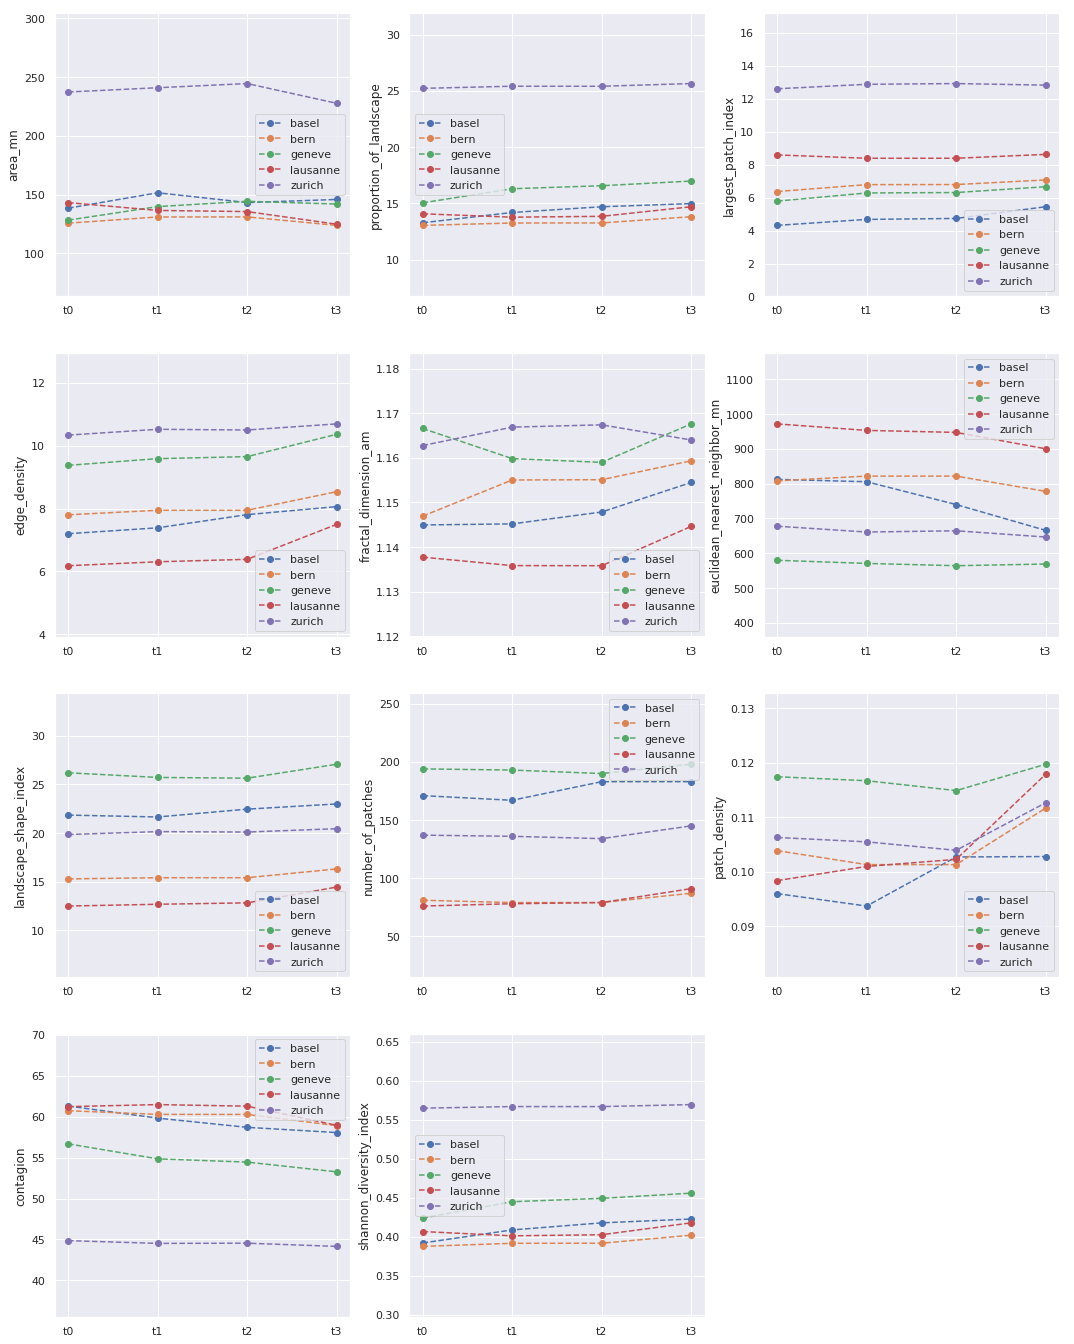

In [21]:
fig, axes = plt.subplots(4, 3, figsize=(3 * 6, 6 * 4))
# plt.setp(axes, xticks=buffer_dists, xlabel="year")
# fig.subplots_adjust()

flat_axes = axes.flat

for i, metric in enumerate(class_metrics):
    for city_slug in city_slugs:
        city_sta_dict[city_slug].plot_metric(metric, class_val=1, ax=flat_axes[i], plot_kws={'label': city_slug})

    flat_axes[i].legend()

for i, metric in enumerate(landscape_metrics, start=len(class_metrics)):
    for city_slug in city_slugs:
        city_sta_dict[city_slug].plot_metric(metric, ax=flat_axes[i], plot_kws={'label': city_slug})
        
    flat_axes[i].legend()

for ax in flat_axes:
    ax.margins(y=.5)
    
for i in range(len(class_metrics + landscape_metrics), len(flat_axes)):
    flat_axes[i].axis('off')

## Basel

(<Figure size 1728x288 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0af783da20>,
       dtype=object))

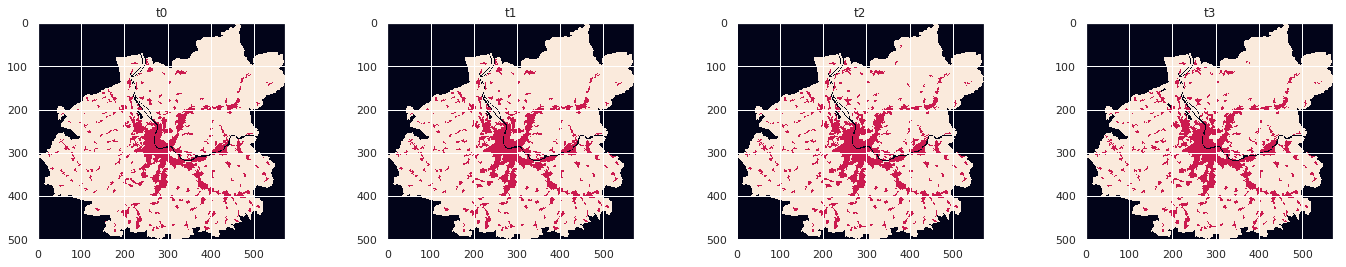

In [106]:
city_sta_dict['basel'].plot_landscapes()

(<Figure size 1296x864 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0aba448908>,
       dtype=object))

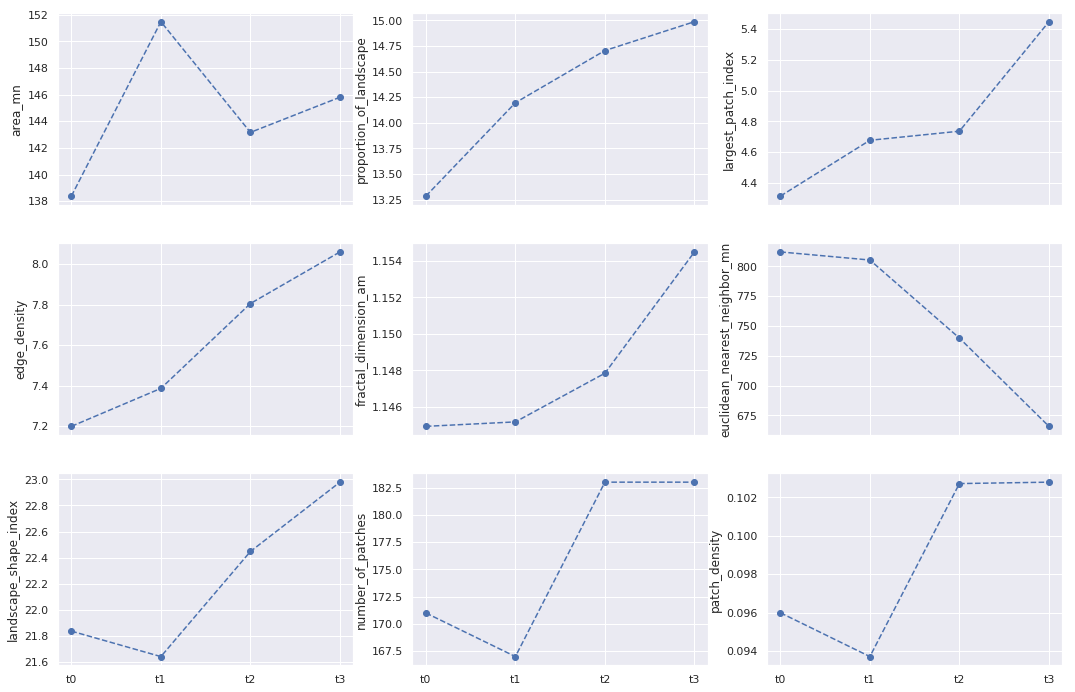

In [22]:
city_sta_dict['basel'].plot_metrics(class_val=1, metrics=class_metrics)

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0abb97de80>,
       dtype=object))

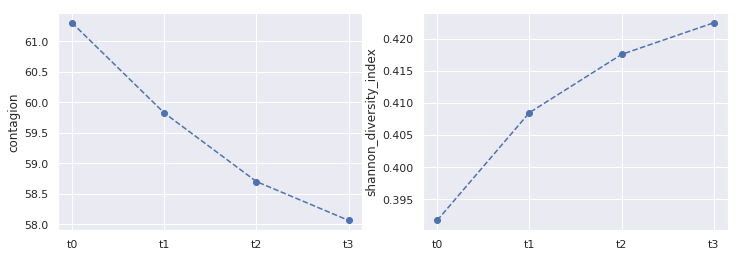

In [25]:
city_sta_dict['basel'].plot_metrics(metrics=landscape_metrics)

## Bern

(<Figure size 1296x864 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0abb9140f0>,
       dtype=object))

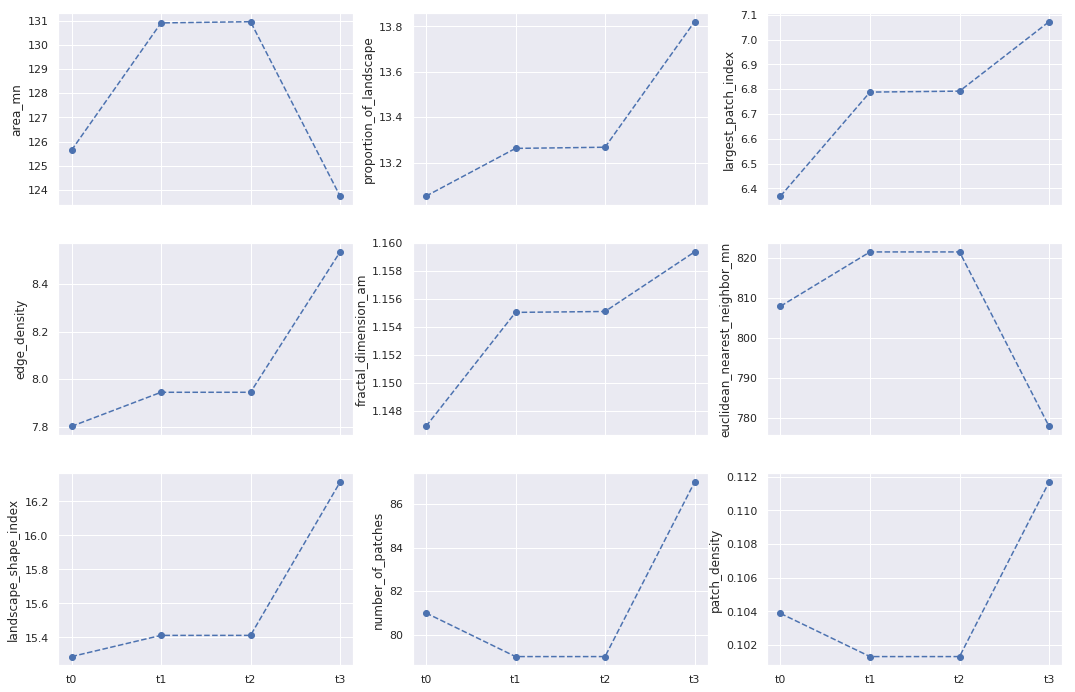

In [26]:
city_sta_dict['bern'].plot_metrics(class_val=1, metrics=class_metrics)

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ab9e25048>,
       dtype=object))

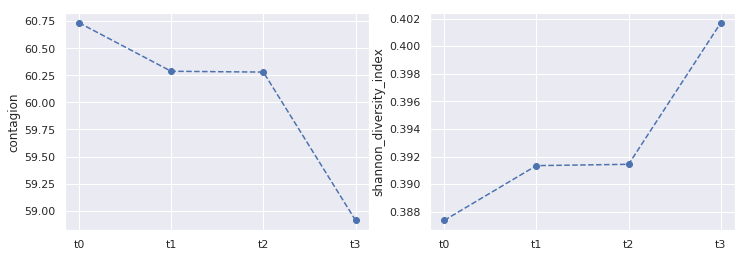

In [27]:
city_sta_dict['bern'].plot_metrics(metrics=landscape_metrics)

## Geneve

(<Figure size 1296x864 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0aaad73898>,
       dtype=object))

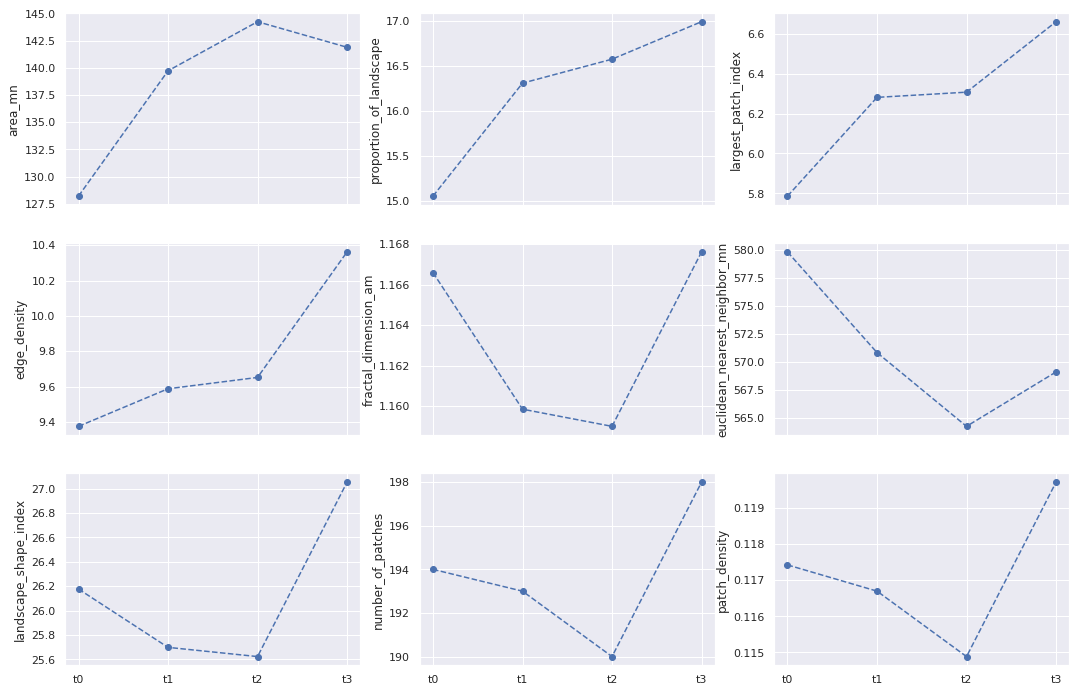

In [100]:
city_sta_dict['geneve'].plot_metrics(class_val=1, metrics=class_metrics)

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0aab4e17b8>,
       dtype=object))

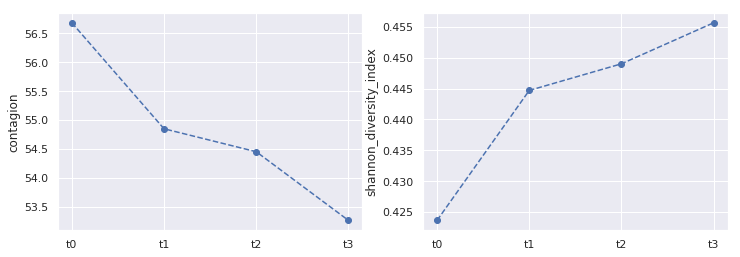

In [101]:
city_sta_dict['geneve'].plot_metrics(metrics=landscape_metrics)

## Lausanne

(<Figure size 1296x864 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0aaae7ed30>,
       dtype=object))

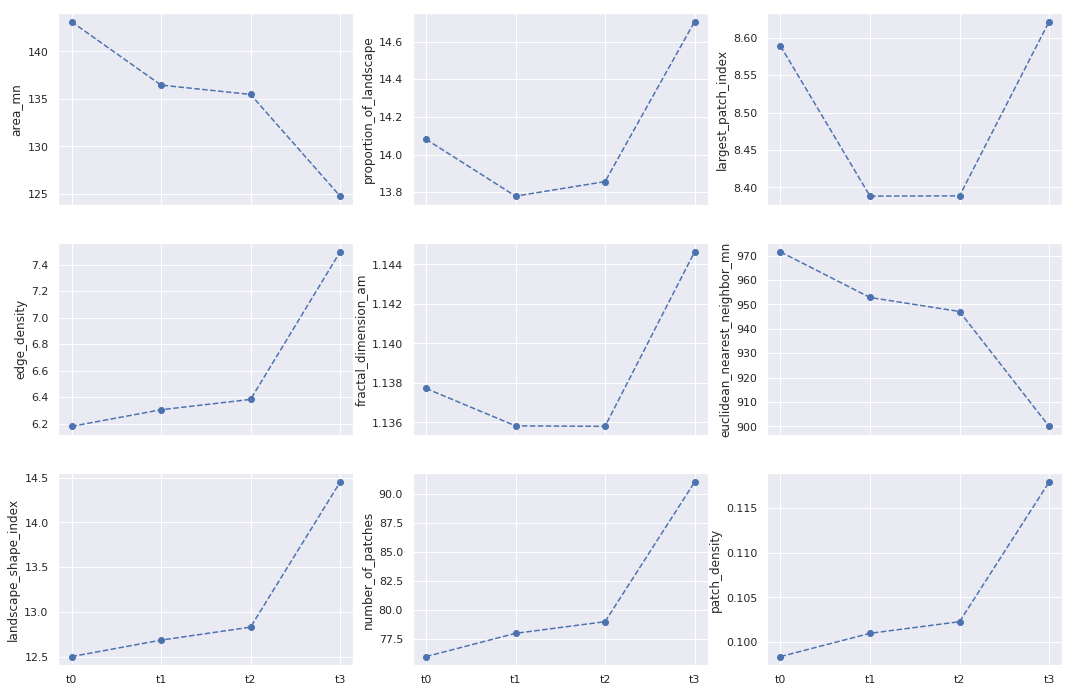

In [102]:
city_sta_dict['lausanne'].plot_metrics(class_val=1, metrics=class_metrics)

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0aaaf1d0f0>,
       dtype=object))

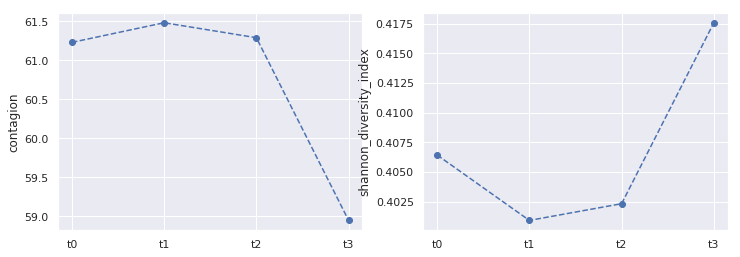

In [103]:
city_sta_dict['lausanne'].plot_metrics(metrics=landscape_metrics)

## Zurich

(<Figure size 1296x864 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0aabc93400>,
       dtype=object))

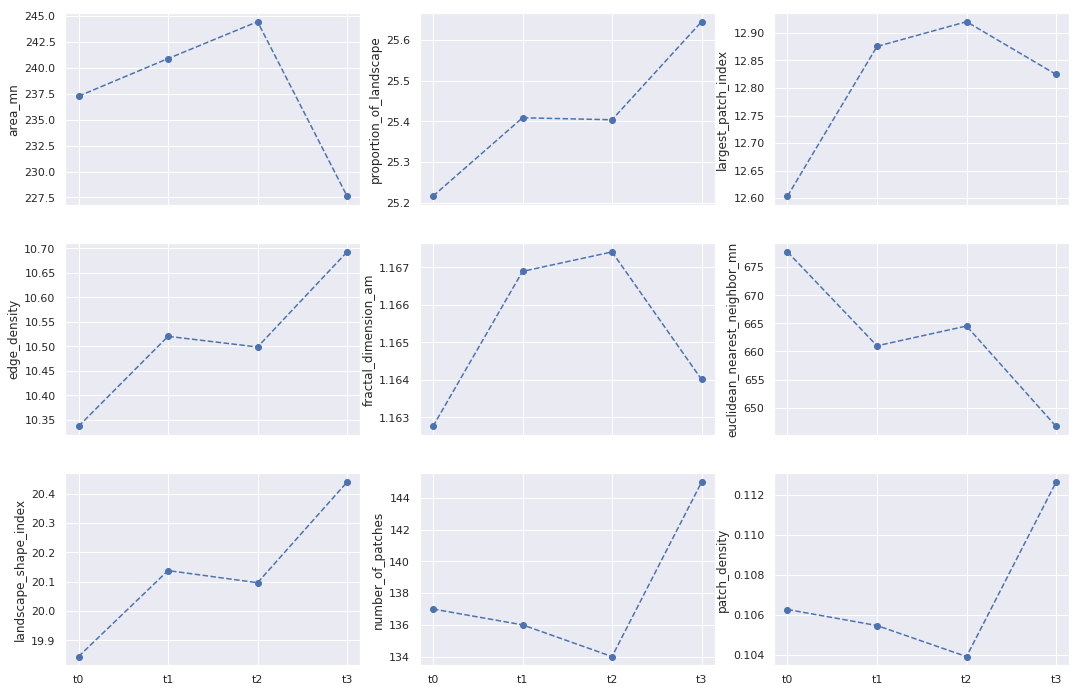

In [105]:
city_sta_dict['zurich'].plot_metrics(class_val=1, metrics=class_metrics)

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0aaafea518>,
       dtype=object))

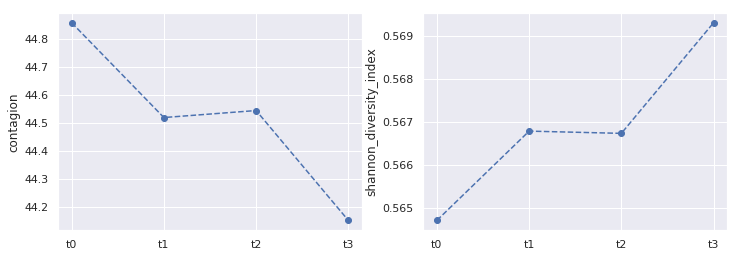

In [104]:
city_sta_dict['zurich'].plot_metrics(metrics=landscape_metrics)

In [315]:
d = {}
for i, j in itertools.combinations_with_replacement(range(1, num_classes + 1), 2):
    d[(i,j)] = i * j

In [330]:
D = np.ndarray((len(d), len(d)))
for (i, j), v in d.items():
    D[i][j] = v
    D[j][i] = v

In [331]:
pd.DataFrame(D)

               0              1              2
0   0.000000e+00  4.940656e-324  9.881313e-324
1  4.940656e-324   1.000000e+00   2.000000e+00
2  9.881313e-324   2.000000e+00   4.000000e+00

In [321]:
list(range(1, num_classes + 1))

[1, 2]

In [322]:
scipy.spatial.distance.squareform(d_list)

array([[0, 1, 2],
       [1, 0, 4],
       [2, 4, 0]])

In [4]:
city_slug = 'lausanne'
year_code = '00'

ls = pls.read_geotiff(
    f'../data/processed/agglomeration_extracts/{city_slug}/{year_code}/{year_code}.tif'
)

In [ ]:
# pladj
G = ls._adjacency_df.values
np.sum(G.diagonal()) / np.sum(G)

0.7556108708071493

In [44]:
ls.contagion()

64.25650171190959

In [24]:
G = ls._adjacency_df.values
np.sum(G.diagonal()) / np.sum(G)

0.958647780486861

In [28]:
ls._adjacency_df

     1.0     2.0   0.0
1  38278    5019   207
2   5019  258968  2577

In [30]:
ls.contagion()

60.892117722998115

496857.26231398224


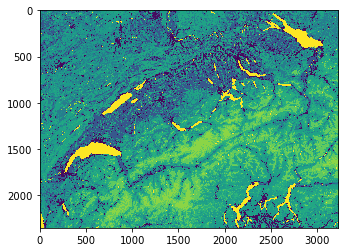

In [303]:
year_code = '00'

ls = pls.read_geotiff(
    f'../data/interim/swiss_extracts/{year_code}/{year_code}.tif'
)
plt.imshow(ls.landscape_arr)
print(ls.total_edge(1))

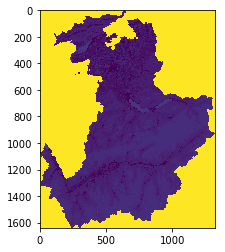

In [374]:
ls = pls.read_geotiff(
    '/home/martibosch/Desktop/foo.tif'
)
plt.imshow(ls.landscape_arr)
# print(ls.total_edge(1))

In [385]:
from numba import jit

ValueError: <module 'numpy.core.numeric' from '/home/martibosch/anaconda3/envs/swiss-urbanization/lib/python3.6/site-packages/numpy/core/numeric.py'> is not globally reachable as 'numpy.core.numeric.ones'

In [381]:
from itertools import combinations_with_replacement

from scipy import ndimage

KERNEL_ABOVE = np.array([[0, 0, 0], [0, 1, 0], [0, 1, 0]], dtype=np.int8)
KERNEL_BELOW = np.array([[0, 1, 0], [0, 1, 0], [0, 0, 0]], dtype=np.int8)
KERNEL_LEFT = np.array([[0, 0, 0], [0, 1, 1], [0, 0, 0]], dtype=np.int8)
KERNEL_RIGHT = np.array([[0, 0, 0], [1, 1, 0], [0, 0, 0]], dtype=np.int8)

In [372]:
def _num_adjacencies(arr, i, j, cval=0):
    arr_ik = np.where(np.isin(arr, [i, j]), arr, 0)
    c = i + j
    adj_ik_above = (ndimage.convolve(
        arr_ik, KERNEL_ABOVE, mode='constant',
        cval=cval) == c) & (arr_ik == i)
    adj_ik_below = (ndimage.convolve(
        arr_ik, KERNEL_BELOW, mode='constant',
        cval=cval) == c) & (arr_ik == i)
    adj_ik_left = (ndimage.convolve(
        arr_ik, KERNEL_LEFT, mode='constant',
        cval=cval) == c) & (arr_ik == i)
    adj_ik_right = (ndimage.convolve(
        arr_ik, KERNEL_RIGHT, mode='constant',
        cval=cval) == c) & (arr_ik == i)
    return np.sum(adj_ik_above) + np.sum(adj_ik_below) + np.sum(
        adj_ik_left) + np.sum(adj_ik_right)

In [375]:
def get_adjacency_table_arr(ls):
    num_classes = len(ls.classes)
    # first prepare a reclassified array of the landscape where we can
    # use a convolution to determine the adjacencies
    reclassified_arr = np.copy(ls.landscape_arr)
    for i, class_val in enumerate(ls.classes, start=1):
        reclassified_arr[ls.landscape_arr == class_val] = i
        reclassified_arr[ls.landscape_arr == ls.nodata] = num_classes + 1

    # now let's prepare the adjacency table. The +1 is to add the
    # border/nodata column at the end
    adjacency_table_arr = np.zeros((num_classes, num_classes + 1),
                                   dtype=np.int)

    # finally let's iterate over all the combinations of classes to
    # apply the convolution and obtain all the adjacencies
    class_range = range(1, num_classes + 1)

    for i, j in combinations_with_replacement(class_range, 2):
        num_adjacencies = _num_adjacencies(reclassified_arr, i, j)
        adjacency_table_arr[i - 1, j - 1] = num_adjacencies
        adjacency_table_arr[j - 1, i - 1] = num_adjacencies

    # nodata
    for i in class_range:
        nodata_j = num_classes + 1
        adjacency_table_arr[i - 1, nodata_j - 1] = _num_adjacencies(
            reclassified_arr, i, nodata_j, cval=nodata_j)    

    return adjacency_table_arr

In [382]:
%time get_adjacency_table_arr(ls)

CPU times: user 38.2 s, sys: 0 ns, total: 38.2 s
Wall time: 38.2 s


array([[  1586,    315,     35,     24,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,     12,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0],
       [   315, 144308,   1122,     88,     70,      7,      0,     45,
           221,  13654,   1480,    509,   4051,   1320,    236,    528,
          3571,   3467,    368,     76,      9,      2,      8,     34,
             0,     27,    225,    681,    174],
       [    35,   1122,   8976,      9,      6,      0,      3,      7,
            82,    724,     60,     82,      0,    124,      0,     18,
           152,    235,      0,      7,      0,      0,      0,      0,
             0,      0,      4,     13,     13],
       [    24,     88,      9,    160,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             4,      3,      0,      0,      0,      0,      

In [371]:
%time ls._adjacency_df

CPU times: user 36.3 s, sys: 80.3 ms, total: 36.4 s
Wall time: 36.4 s


    1.0     2.0    3.0    4.0    6.0    7.0    9.0    10.0   11.0    12.0   \
1    1586     315     35     24      0      0      0      0      0       0   
2     315  144308   1122     88     70      7      0     45    221   13654   
3      35    1122   8976      9      6      0      3      7     82     724   
4      24      88      9    160      0      0      0      0      0       0   
6       0      70      6      0   2476      0      0      0      0     248   
7       0       7      0      0      0   1054      0      0      9      89   
9       0       0      3      0      0      0    172      0      0      21   
10      0      45      7      0      0      0      0    136      0       0   
11      0     221     82      0      0      9      0      0   2356     129   
12      0   13654    724      0    248     89     21      0    129  498996   
15      0    1480     60      0     10      5      0      0     13     127   
16      0     509     82      0      0     44      0      0     

In [309]:
ls.compute_class_metrics_df(['total_edge'])

             total_edge
class_val              
1          3.860124e+04
2          3.211536e+06
3          2.683104e+05
4          1.280017e+04
6          6.320097e+04
7          3.540159e+04
9          7.200398e+03
10         5.200202e+03
11         6.160223e+04
12         5.724442e+06
15         3.956141e+05
16         1.714064e+05
18         6.327584e+06
20         7.603303e+05
21         2.892125e+05
23         6.542230e+05
24         1.037939e+07
25         6.493774e+06
26         6.259289e+06
27         1.684175e+06
29         4.092170e+05
30         9.660430e+04
31         6.090272e+06
32         4.313502e+06
34         2.717328e+06
35         3.070172e+04
40         1.054017e+05
41         3.578149e+05

In [367]:
ls = pls.read_geotiff(
    '../data/processed/agglomeration_extracts/lausanne/06/06.tif'
)

In [359]:
# convolution
%time ls._adjacency_df

CPU times: user 31 ms, sys: 0 ns, total: 31 ms
Wall time: 30.7 ms


     1.0     2.0   0.0
1  37312    5069   183
2   5069  259834  2601

In [369]:
# sparse
%time ls._adjacency_df

ValueError: Shape of passed values is (3, 3), indices imply (2, 3)

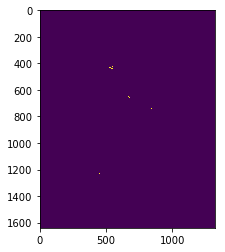

In [259]:
plt.imshow(ls.landscape_arr == 1)

-3135402
[-3 -3 -3 ... -3 -3 -3]


TypeError: Invalid dimensions for image data

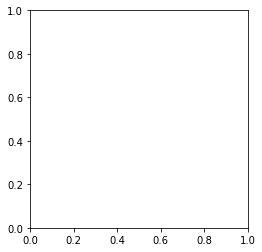

TypeError: Invalid dimensions for image data

In [218]:
ls.compute_arr_edge(ls.landscape_arr == 1)

In [158]:
%timeit
ls.compute_class_metrics_df(metrics=['edge_density'])
ls.compute_landscape_metrics_df(metrics=['edge_density'])

CPU times: user 1.79 s, sys: 5 µs, total: 1.79 s
Wall time: 1.79 s


           proportion_of_landscape     area_mn  fractal_dimension_mn
class_val                                                           
1                         0.044096   70.435378              1.074887
2                         3.948835  105.377726              1.089766
3                         0.260996   57.221216              1.087842
4                         0.006440   36.003479              1.147130
6                         0.069497   70.643191              1.081236
7                         0.031484   44.004253              1.077872
9                         0.005456   30.502948              1.078086
10                        0.004204   47.004543              1.097984
11                        0.066456   53.076558              1.066021
12                       12.488797  750.760728              1.080363
15                        0.567876  204.826247              1.099155
16                        0.332908  338.396340              1.105703
18                        8.227805

In [152]:
%time ls.contagion()

CPU times: user 37.4 s, sys: 0 ns, total: 37.4 s
Wall time: 37.4 s


55.50904585950338

In [150]:
%time ls._patch_euclidean_nearest_neighbor_ser

CPU times: user 4min 19s, sys: 7.8 ms, total: 4min 19s
Wall time: 4min 19s


0       23586.092568
1         360.572551
2         316.243048
3         316.243048
4       18113.025884
5       18113.025884
6       61194.541460
7         300.014497
8         900.043492
9         300.014497
10        424.284571
11        424.284571
12       4314.139392
13        316.243048
14       1341.705621
15       1711.806996
16        670.852811
17        921.998999
18        921.998999
19       1334.230880
20        583.123367
21       2844.429981
22        400.019330
23        400.019330
24        316.243048
25        360.572551
26        632.486095
27        447.235207
28        538.542504
29        800.038660
            ...     
4078     7225.305892
4079     6122.386995
4080     2828.563808
4081      223.617604
4082      223.617604
4083    11017.337729
4084    16733.112670
4085     5012.227838
4086     3700.178802
4087     3700.178802
4088     2202.377979
4089      854.441663
4090      854.441663
4091     1236.991462
4092    11205.004850
4093    11860.589996
4094    27282

In [147]:
%time ls._adjacency_df

CPU times: user 1.44 s, sys: 4 ms, total: 1.44 s
Wall time: 1.44 s


    1.0    2.0    3.0    4.0    6.0    7.0    10.0   11.0    12.0   15.0   \
1    1688    180     45      0      0      0      8     15       9      0   
2     180  28732    278     62      4      2    167     88    3541    302   
3      45    278   2048      0      0      0     28     18      50      0   
4       0     62      0    158      0      0      0      0       0      5   
6       0      4      0      0    120      0      0      3      25      0   
7       0      2      0      0      0    326      0      0      65      0   
10      8    167     28      0      0      0    752      1       0      0   
11     15     88     18      0      3      0      1    758      35      0   
12      9   3541     50      0     25     65      0     35  167102    250   
15      0    302      0      5      0      0      0      0     250   2994   
16      0     13      6      0      0      0      0      0      37      0   
18      0      0      0      0      0      0      0      0       4      0   

In [344]:
%time g = image.img_to_graph(ls.landscape_arr)

CPU times: user 2.62 s, sys: 871 ms, total: 3.49 s
Wall time: 3.49 s


In [5]:
g = image.img_to_graph(ls.landscape_arr)

NameError: name 'image' is not defined

In [357]:
len(g.diagonal())

7593730

In [355]:
len(g.diagonal(k=1))

7593729

In [356]:
len(g.diagonal(k=-1))

7593729

In [337]:
np.concatenate([ls.classes, [ls.nodata]])

array([1., 2., 0.])

In [334]:
# with itertools, for Lausanne urban extract (2 classes)
%time ls._adjacency_table_arr

CPU times: user 30.3 ms, sys: 101 µs, total: 30.4 ms
Wall time: 30.2 ms


array([[ 38278,   5019,    207],
       [  5019, 258968,   2577]])

In [304]:
# without itertools, for Lausanne urban extract (2 classes)
%time ls._adjacency_table_arr

CPU times: user 36.4 ms, sys: 3 µs, total: 36.4 ms
Wall time: 36.2 ms


array([[ 38278,   5019,    207],
       [  5019, 258968,   2577]])

In [294]:
ls._adjacency_table_arr

array([[ 38278,   5019,    207],
       [  5019, 258968,   2577]])

In [69]:
arr = np.array([[1, 0, 1], [1, 1, 1], [0, 1, 1]])
arr

array([[1, 0, 1],
       [1, 1, 1],
       [0, 1, 1]])

In [78]:
ndi.convolve(arr, KERNEL_ABOVE, mode='constant', cval=0)

array([[2, 1, 2],
       [1, 2, 2],
       [0, 1, 1]])

In [79]:
ndi.convolve(arr, KERNEL_BELOW, mode='constant', cval=0)

array([[1, 0, 1],
       [2, 1, 2],
       [1, 2, 2]])

In [102]:
arr = np.array([
    [1, 0, 2, 1],
    [1, 1, 2, 1],
    [1, 1, 1, 1],
    [1, 3, 1, 1]
], dtype=np.int8)

ls = pls.Landscape(arr, res=(1,1), nodata=0)
reclassified_arr = np.copy(ls.landscape_arr)
dfor i, class_val in enumerate(ls.classes, start=1):
    reclassified_arr[ls.landscape_arr == class_val] = i
reclassified_arr[ls.landscape_arr == ls.nodata] = num_classes + 1
# TODO: operate over diagonal of `img_to_graph`
g = image.img_to_graph(reclassified_arr, return_as=scipy.sparse.csr.csr_matrix) #, return_as=np.ndarray)
# hint: use the following trick to separate between no adjacency (0) and nodata
# g = image.img_to_graph(np.where(arr != 0, arr, -1), return_as=np.ndarray)

In [139]:
import numpy as np
import scipy.sparse as s

def connected_adjacency(image, patch_size=(1, 1)):
    """
    Creates an adjacency matrix from an image where nodes are considered adjacent 
    based on 4-connected or 8-connected pixel neighborhoods.

    :param image: 2 or 3 dim array
    :param connect: string, either '4' or '8'
    :param patch_size: tuple (n,m) used if the image will be decomposed into 
                   contiguous, non-overlapping patches of size n x m. The 
                   adjacency matrix will be formed from the smaller sized array
                   e.g. original image size = 256 x 256, patch_size=(8, 8), 
                   then the image under consideration is of size 32 x 32 and 
                   the adjacency matrix will be of size 
                   32**2 x 32**2 = 1024 x 1024
    :return: adjacency matrix as a sparse matrix (type=scipy.sparse.csr.csr_matrix)
    """

    r, c = image.shape[:2]

    r = r // patch_size[0]
    c = c // patch_size[1]

    # constructed from 2 diagonals above the main diagonal
    d1 = np.tile(np.append(np.ones(c-1), [0]), r)[:-1]
    d2 = np.ones(c*(r-1))
    upper_diags = s.diags([d1, d2], [1, c])
    
    return (upper_diags + upper_diags.T).astype(np.uint8)

In [324]:
ls = pls.Landscape(reclassified_arr, res=(1,1))

In [316]:
reclassified_arr

array([[1, 4, 2, 1],
       [1, 1, 2, 1],
       [1, 1, 1, 1],
       [1, 3, 1, 1]], dtype=int8)

In [354]:
num_classes = len(np.unique(reclassified_arr))
adjacency_table_arr = np.zeros((num_classes, num_classes + 1), dtype=np.int)
adjacency_connexions_arr = connected_adjacency(reclassified_arr).astype(bool) # .toarray().astype(bool)

flat_arr = reclassified_arr.flatten()
for class_i, adj_row in zip(flat_arr, adjacency_connexions_arr):
    # print(class_i)
    # print(adj_row.A)
    # print(flat_arr)
    # print(flat_arr[adj_row])
    for class_k in flat_arr[adj_row.A[0]]:
        adjacency_table_arr[class_i - 1, class_k - 1] += 1

all_borders = np.concatenate((reclassified_arr[[0,num_classes-1],:].ravel(), reclassified_arr[1:-1,[0,num_classes-1]].ravel()))
for class_val, count in zip(*np.unique(all_borders, return_counts=True)):
    adjacency_table_arr[class_val - 1, -1] += count        

In [355]:
adjacency_table_arr

array([[26,  4,  3,  2,  9],
       [ 4,  2,  0,  1,  1],
       [ 3,  0,  0,  0,  1],
       [ 2,  1,  0,  0,  1]])

In [329]:
class_values, counts = np.unique(reclassified_arr[0,:], return_counts=True)

1 2
2 1
4 1


In [330]:
for classclass_values

array([1, 2, 4], dtype=int8)

In [ ]:
image.img_to_graph(reclassified_arr, return_as=np.ndarray)

array([[1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 4, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 3, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int8)

In [105]:
num_classes = len(ls.classes)

In [112]:
nonzero_rows[nonzero_rows > 11]

array([14, 15], dtype=int32)

In [123]:
num_classes = len(ls.classes)
adjacency_table_arr = np.zeros((num_classes + 1, num_classes + 1), dtype=np.int)

for row_i, (class_i, nonzero_rows) in enumerate(zip(g.diagonal(), np.split(g.indices, g.indptr[1:-1]))):
    print(class_i, g[row_i, nonzero_rows[nonzero_rows > row_i]].A)
    print(class_i, g[row_i, :].A)
    for class_k in g[i, nonzero_rows].A[0]:
        adjacency_table_arr[class_i - 1, class_k - 1] += 1
        # adjacency_table_arr[class_k - 1, class_i - 1] += 1

1 [[3 0]]
1 [[1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
4 [[2 3]]
4 [[3 4 2 0 0 3 0 0 0 0 0 0 0 0 0 0]]
2 [[1 0]]
2 [[0 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0]]
1 [[0]]
1 [[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]]
1 [[0 0]]
1 [[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]]
1 [[1 0]]
1 [[0 3 0 0 0 1 1 0 0 0 0 0 0 0 0 0]]
2 [[1 1]]
2 [[0 0 0 0 0 1 2 1 0 0 1 0 0 0 0 0]]
1 [[0]]
1 [[0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]]
1 [[0 0]]
1 [[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]
1 [[0 2]]
1 [[0 0 0 0 0 0 0 0 0 1 0 0 0 2 0 0]]
1 [[0 0]]
1 [[0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0]]
1 [[0]]
1 [[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]
1 [[2]]
1 [[0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0]]
3 [[2]]
3 [[0 0 0 0 0 0 0 0 0 2 0 0 2 3 2 0]]
1 [[0]]
1 [[0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0]]
1 []
1 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


In [120]:
adjacency_table_arr

array([[ 3,  0,  0, 44],
       [ 3,  0,  0,  6],
       [ 0,  0,  0,  4],
       [ 1,  0,  0,  3]])

In [71]:
nonzero_cols

array([ 1,  2,  3,  6,  7, 13, 14,  5, 10, 13,  0,  1,  2,  5,  6, 12, 13,
        1,  6,  9,  0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15], dtype=int32)

In [76]:
nonzero_rows, nonzero_cols = g.nonzero()
for i, v in enumerate(g.diagonal()):
    if i in nonzero_rows:
        for class_val in ls.classes:
            row = g.getrow(i)
            # print(nonzero_cols[nonzero_rows == i])
            # print(row.tocsr()[nonzero_cols[nonzero_rows == i]])
            print(row.tocsr()[nonzero_cols])
            # print(v, np.sum(row == v))
            # adjacency

IndexError: index (15) out of range

In [436]:
for i in g.shape[0]:
    g.getrow()

TypeError: getrow() missing 1 required positional argument: 'i'

In [428]:
g.nonzero()

(array([ 0,  1,  2,  5,  6, 12, 13,  1,  6,  9,  1,  2,  3,  6,  7, 13, 14,
         5, 10, 13,  0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
        15], dtype=int32),
 array([ 1,  2,  3,  6,  7, 13, 14,  5, 10, 13,  0,  1,  2,  5,  6, 12, 13,
         1,  6,  9,  0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
        15], dtype=int32))

In [426]:
for row in g:
    print(row[0])

TypeError: 'coo_matrix' object is not subscriptable

In [425]:
g

<16x16 sparse matrix of type '<class 'numpy.int8'>'
	with 64 stored elements in COOrdinate format>

In [367]:
g.diagonal()

array([1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1], dtype=int8)

In [368]:
g.diagonal(k=1)  # k=1 and k=-1 are the same since `g` is symmetric

array([1, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 2, 0], dtype=int8)

In [418]:
foo_arr = np.array([np.concatenate([[0], g.diagonal(k=1)]), g.diagonal(), np.concatenate([g.diagonal(k=1), [0]])])
# foo_arr = foo_arr[:, :7]
foo_arr

array([[0, 1, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 2, 0],
       [1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1],
       [1, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0]])

In [419]:
i, j = 1, 2
i_arr = foo_arr == i
j_arr = foo_arr == j

In [420]:
num_cols = len(foo_arr[0])
middle_row = np.array([np.full(num_cols, False), np.full(num_cols, True), np.full(num_cols, False)])

In [424]:
# credits to user3717023 answer in https://stackoverflow.com/questions/38073433/determine-adjacent-regions-in-numpy-array
# check vertical adjacency
i_roll_below = np.roll(i_arr, 1, axis=0)
i_roll_below[0, :] = False

i_roll_above = np.roll(i_arr, -1, axis=0)
i_roll_above[-1, :] = False

# check horizontal adjacency
# i_roll_right = np.roll(i_arr, 1, axis=1)
# i_roll_right[:, 0] = False

# i_roll_left = np.roll(i_arr, -1, axis=1)
# i_roll_right[:, -1] = False

# z = np.logical_or(j_arr, rolled)
for i_roll in [i_roll_below, i_roll_above]:  #, i_roll_right, i_roll_left]:
    adj_ij_arr = np.logical_and(i_roll, np.logical_and(middle_row, j_arr)).astype(int)
    print(adj_ij_arr)
    print(np.sum(adj_ij_arr))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
1
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
2


In [406]:
rolled.astype(int)

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 1],
       [1, 0, 0, 1, 1, 1, 0]])

array([[False, False, False, False, False, False, False],
       [False, False, False, False, False, False,  True],
       [False, False, False, False, False, False, False]])

In [ ]:
(i_arr[1:, :] != i_arr[:-1, :]).astype(int)

array([[1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
       [0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]])

In [390]:
np.roll(i_arr.astype(int), 1, axis=0)

array([[1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]])

In [387]:
i_arr.astype(int)

array([[0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [384]:
j_arr

array([[False, False,  True, False, False, False, False, False, False,
        False, False, False, False,  True,  True, False],
       [False, False,  True, False, False, False,  True, False, False,
        False, False, False, False, False, False, False],
       [False,  True, False, False, False, False, False, False, False,
        False, False, False,  True,  True, False, False]])

In [ ]:
def num_adjacencies(foo_arr, i, j):
    foo_arr == i


In [374]:
for i, j in itertools.combinations_with_replacement(ls.classes, 2):
    print(i, j)

1 1
1 2
1 3
2 2
2 3
3 3


In [207]:
adj = pd.read_csv('/home/martibosch/Desktop/bar.adj', header=1, index_col=0)
adj

                1   2   3   background
Class ID / ID                         
1              26   4   3           15
2               4   2   0            2
3               3   0   0            1

In [208]:
np.concatenate([ls.classes, [ls.nodata]])

array([1, 2, 3, 0])

In [265]:
foo_arr = np.copy(ls.landscape_arr)
foo_arr[foo_arr == ls.nodata] = len(ls.classes) + 1
for i, class_val in enumerate(ls.classes, start=1):
    foo_arr[foo_arr == class_val] = i

In [266]:
foo_arr

array([[1, 4, 2, 1],
       [1, 1, 2, 1],
       [1, 1, 1, 1],
       [1, 3, 1, 1]], dtype=int8)

In [278]:
arr = np.array([[True, True, False], [False, False, True], [False, True, False]])

In [281]:
arr2 = np.copy(arr)
arr2[0, 0] = False

In [288]:
(ndi.convolve(arr_ik, KERNEL_ABOVE, mode='constant', cval=0) == c) & (arr_ik == i)

array([[ True, False, False,  True],
       [ True,  True, False,  True],
       [ True, False,  True,  True],
       [False, False, False, False]])

In [292]:
adj = np.zeros((m, m+1), dtype=np.int)

for i, _ in enumerate(ls.classes, start=1):
    for j, _ in enumerate(ls.classes, start=1):
        arr_ik = np.where(np.isin(foo_arr, [i, j]), foo_arr, 0)
        c = i + j
        adj_ik_above = (ndi.convolve(arr_ik, KERNEL_ABOVE, mode='constant', cval=0) == c) & (arr_ik == i)
        adj_ik_below = (ndi.convolve(arr_ik, KERNEL_BELOW, mode='constant', cval=0) == c) & (arr_ik == i)
        adj_ik_left = (ndi.convolve(arr_ik, KERNEL_LEFT, mode='constant', cval=0) == c) & (arr_ik == i)
        adj_ik_right = (ndi.convolve(arr_ik, KERNEL_RIGHT, mode='constant', cval=0) == c) & (arr_ik == i)
        adj[i-1, j-1] = np.sum(adj_ik_above) + np.sum(adj_ik_below) + np.sum(adj_ik_left) + np.sum(adj_ik_right)

    # nodata        
    arr_ik = np.where(np.isin(foo_arr, [i, j + 1]), foo_arr, 0)
    c = i + j + 1
    adj_ik_above = (ndi.convolve(arr_ik, KERNEL_ABOVE, mode='constant', cval=j+1) == c) & (arr_ik == i)
    adj_ik_below = (ndi.convolve(arr_ik, KERNEL_BELOW, mode='constant', cval=j+1) == c) & (arr_ik == i)
    adj_ik_left = (ndi.convolve(arr_ik, KERNEL_LEFT, mode='constant', cval=j+1) == c) & (arr_ik == i)
    adj_ik_right = (ndi.convolve(arr_ik, KERNEL_RIGHT, mode='constant', cval=j+1) == c) & (arr_ik == i)
    
    adj[i-1, -1] = np.sum(adj_ik_above) + np.sum(adj_ik_below) + np.sum(adj_ik_left) + np.sum(adj_ik_right)

    # arr_ik = np.where(np.isin(foo_arr, [i, j + 1]), foo_arr, 0)
    # print(i)
    # print(arr_ik)
    # c = i + j + 1
    # print(c)
    # adj_ik_above = ndi.convolve(arr_ik, KERNEL_ABOVE, mode='constant', cval=j+1) == c
    # adj_ik_below = ndi.convolve(arr_ik, KERNEL_BELOW, mode='constant', cval=j+1) == c
    # adj_ik_left = ndi.convolve(arr_ik, KERNEL_LEFT, mode='constant', cval=j+1) == c
    # adj_ik_right = ndi.convolve(arr_ik, KERNEL_RIGHT, mode='constant', cval=j+1) == c        
    # print(ndi.convolve(arr_ik, KERNEL_ABOVE, mode='constant', cval=j+1))
    # print(ndi.convolve(arr_ik, KERNEL_BELOW, mode='constant', cval=j+1))
    # print(ndi.convolve(arr_ik, KERNEL_LEFT, mode='constant', cval=j+1))
    # print(ndi.convolve(arr_ik, KERNEL_RIGHT, mode='constant', cval=j+1))
    # print()
    # adj[i-1, -1] = np.sum(adj_ik_above) + np.sum(adj_ik_below) + np.sum(adj_ik_left) + np.sum(adj_ik_right)
    
    # c = i + -1
    # adj_ik_horiz = ndi.convolve(arr_ik, KERNEL_ABOVE, mode='constant', cval=ls.nodata) == c
    # adj_ik_vert = ndi.convolve(arr_ik, KERNEL_LEFT, mode='constant', cval=ls.nodata) == c
    # print(i, ls.nodata)
    # print(arr_ik)
    # print(ndi.convolve(arr_ik, KERNEL_ABOVE, mode='constant', cval=ls.nodata))
    # print(ndi.convolve(arr_ik, KERNEL_LEFT, mode='constant', cval=ls.nodata))
    # print()
    # adj[row, col + 1] = np.sum(adj_ik_horiz) + np.sum(adj_ik_vert)
    
print(adj)

[[26  4  3 15]
 [ 4  2  0  2]
 [ 3  0  0  1]]


In [240]:
adj = np.zeros((m, m+1), dtype=np.int)

for i, _ in enumerate(ls.classes, start=1):
    for j, _ in enumerate(ls.classes):
        arr_ik = np.where(np.isin(foo_arr, [i, k]), foo_arr, ls.nodata)
        c = i + k

        adj_ik_horiz = ndi.convolve(arr_ik, KERNEL_ABOVE, mode='constant', cval=0) == c
        adj_ik_vert = ndi.convolve(arr_ik, KERNEL_LEFT, mode='constant', cval=0) == c
        
        if i == k:
            # adj[row, col] = np.sum(adj_ik_above) + np.sum(adj_ik_below) + np.sum(adj_ik_left) + np.sum(adj_ik_right)
            adj[row, col] = 2 * (np.sum(adj_ik_horiz) + np.sum(adj_ik_vert))
        else:
            # g[row, col] = np.sum(adj_ik_above) + np.sum(adj_ik_left)
            adj[row, col] = np.sum(adj_ik_horiz) + np.sum(adj_ik_vert)
            
    arr_ik = np.where(ls.landscape_arr != ls.nodata, i, ls.nodata)
    c = i + ls.nodata        
    adj_ik_horiz = ndi.convolve(arr_ik, KERNEL_ABOVE, mode='constant', cval=ls.nodata) == c
    adj_ik_vert = ndi.convolve(arr_ik, KERNEL_LEFT, mode='constant', cval=ls.nodata) == c
    print(i, ls.nodata)
    print(arr_ik)
    print(ndi.convolve(arr_ik, KERNEL_ABOVE, mode='constant', cval=ls.nodata))
    print(ndi.convolve(arr_ik, KERNEL_LEFT, mode='constant', cval=ls.nodata))
    print()
    adj[row, col + 1] = np.sum(adj_ik_horiz) + np.sum(adj_ik_vert)
    
print(adj)
# for j in range(len(ls.classes)):
#     print(g[j, j])
#     print(np.sum(g[j, :]))
#     print(g[j, j] / np.sum(g[j, :]))

1 0
[[1 0 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
[[2 1 2 2]
 [2 2 2 2]
 [2 2 2 2]
 [1 1 1 1]]
[[1 1 2 1]
 [2 2 2 1]
 [2 2 2 1]
 [2 2 2 1]]

2 0
[[2 0 2 2]
 [2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]]
[[4 2 4 4]
 [4 4 4 4]
 [4 4 4 4]
 [2 2 2 2]]
[[2 2 4 2]
 [4 4 4 2]
 [4 4 4 2]
 [4 4 4 2]]

3 0
[[3 0 3 3]
 [3 3 3 3]
 [3 3 3 3]
 [3 3 3 3]]
[[6 3 6 6]
 [6 6 6 6]
 [6 6 6 6]
 [3 3 3 3]]
[[3 3 6 3]
 [6 6 6 3]
 [6 6 6 3]
 [6 6 6 3]]

[[26  4  3 11]
 [ 4  2  0 11]
 [ 3  0  0 11]]


In [ ]:
_contag

-0.44361360611729383

In [139]:
ls.landscape_arr

array([[1, 1, 2, 1],
       [1, 1, 2, 1],
       [1, 1, 1, 1],
       [1, 3, 1, 1]], dtype=int8)

In [94]:
# for i, k in itertools.product(ls.classes, ls.classes)
m = len(ls.classes)

_contag = 0

for i in ls.classes:
    p_i = np.sum(ls._get_patch_area_ser(i)) / ls.landscape_area
    g_ik = np.zeros(m, dtype=np.int)
    for j, k in enumerate(ls.classes):
        arr_ik = np.where(np.isin(ls.landscape_arr, [i, k]), ls.landscape_arr, ls.nodata)
        # g_ik = ls.landscape_arr ==
        c = i + k
        adj_ik_above = ndi.convolve(arr_ik, KERNEL_ABOVE, mode='constant', cval=0) == c
        adj_ik_below = ndi.convolve(arr_ik, KERNEL_BELOW, mode='constant', cval=0) == c
        adj_ik_left = ndi.convolve(arr_ik, KERNEL_LEFT, mode='constant', cval=0) == c
        adj_ik_right = ndi.convolve(arr_ik, KERNEL_RIGHT, mode='constant', cval=0) == c    
        # print(i, k)
        # print(arr_ik)
        # print(np.sum(adj_ik_above), np.sum(adj_ik_below))
        # print(np.sum(adj_ik_left), np.sum(adj_ik_right))
        # print()
        g_ik[j] = np.sum(adj_ik_above) + np.sum(adj_ik_below) + np.sum(adj_ik_left) + np.sum(adj_ik_right)

    g_i = np.sum(g_ik)
    for j, k in enumerate(ls.classes):
        g = g_ik[j] / g_i
        _contag += p_i * g * np.log(p_i) * g

contag = 1 + _contag / 2 * np.log(m)

In [8]:
ls._adjacency_df

     1.0     2.0   0.0
1  38278    5019   207
2   5019  258968  2577

In [95]:
contag

0.7563203204495832

In [5]:
ls.landscape_arr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [13]:
import numpy as np

from sklearn.feature_extraction import image

In [16]:
g = image.img_to_graph(arr, return_as=np.ndarray)